# MIP - CVRP

$$
\begin{align}
    \text{min} \quad & \sum_{k \in K}\sum_{i \in V}\sum_{j \in V} c_{i, j} x_{i, j, k} \\
    \text{s.t} \quad & \sum_{k \in K}\sum_{j \in V} x_{i, j, k} = \sum_{k \in K}\sum_{j \in V} x_{j, i, k} = 1 & \forall \; i \in V \setminus \{0\} \\
    & \sum_{j \in V} x_{i, j, k} = \sum_{j \in V} x_{j, i, k} = y_{i, k} & \forall \; i \in V \setminus \{0\} \; k \in K \\
    & \sum_{i \in V} q_{i} y_{i, k} \leq Q & \forall \; k \in K \\
    & \sum_{k \in K}\sum_{j \in V} x_{0, j, k} = \sum_{k \in K}\sum_{i \in V} x_{i, 0, k} = K \\
    & \sum_{i \in S}\sum_{j \notin S} x_{i, j, k} \geq y_{h, k} & \forall \; S \subseteq V \setminus \{0\} \; h \in S \; k \in K \\
    & x_{i, j, k} \in \{0, 1\} & \forall \; i \in V \; j \in V \; k \in K \\
    & y_{i, k} \in \{0, 1\} & \forall \; i \in V \; k \in K
\end{align}
$$

In [33]:
import time
from itertools import cycle

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers.highs import Highs

In [34]:
from bpp import create_bpp

## Random parameters

In [35]:
np.random.seed(42)

N = 10
demands = np.random.randint(1, 10, size=N)
demands[0] = 0

capacity = 15
# n_vehicles = 4

coordinates = np.random.rand(N, 2)
distances = squareform(pdist(coordinates, metric="euclidean"))
distances = np.round(distances, decimals=4)

### Optional - BPP

In [36]:
bpp = create_bpp({i: d for (i, d) in enumerate(demands)}, capacity)

In [37]:
# solver = pyo.SolverFactory("cbc", heuristics="on")
solver = Highs()
solver.highs_options = {
    "log_file": "Highs.log",
    "mip_heuristic_effort": 0.2,
    "mip_detect_symmetry": True,
    "mip_rel_gap": 1e-6,
}
solver.solve(bpp)
n_vehicles = int(bpp.obj())
print(f"{n_vehicles} vehicles are necessary")

4 vehicles are necessary


## CVRP

In [38]:
model = pyo.ConcreteModel()

## Sets

In [39]:
model.V = pyo.Set(initialize=range(len(demands)))
model.A = pyo.Set(initialize=[(i, j) for i in model.V for j in model.V if i != j])
model.K = pyo.Set(initialize=range(n_vehicles))

## Parameters

In [40]:
model.Q = pyo.Param(initialize=capacity)
model.c = pyo.Param(model.A, initialize={(i, j): distances[i, j] for (i, j) in model.A})
model.q = pyo.Param(model.V, initialize={i: d for (i, d) in enumerate(demands)})

## Variables

In [41]:
model.x = pyo.Var(model.A, model.K, within=pyo.Binary)
model.y = pyo.Var(model.V, model.K, within=pyo.Binary)

## Constraints

In [42]:
def arcs_in(model, i):
    if i == model.V.first():
        return sum(model.x[:, i, :]) == len(model.K)
    else:
        return sum(model.x[:, i, :]) == 1.0


def arcs_out(model, i):
    if i == model.V.first():
        return sum(model.x[i, :, :]) == len(model.K)
    else:
        return sum(model.x[i, :, :]) == 1.0


def vehicle_assignment(model, i, k):
    return sum(model.x[:, i, k]) == model.y[i, k]


def comp_vehicle_assignment(model, i, k):
    return sum(model.x[i, :, k]) == model.y[i, k]


def capacity_constraint(model, k):
    return sum(model.y[i, k] * model.q[i] for i in model.V) <= model.Q


def subtour_elimination(model, S, Sout, h, k):
    nodes_out = sum(model.x[i, j, k] for i in S for j in Sout)
    return model.y[h, k] <= nodes_out


model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.vehicle_assignment = pyo.Constraint(model.V, model.K, rule=vehicle_assignment)
model.comp_vehicle_assignment = pyo.Constraint(model.V, model.K, rule=comp_vehicle_assignment)
model.capacity_constraint = pyo.Constraint(model.K, rule=capacity_constraint)
model.subtour_elimination = pyo.ConstraintList()

## Objective

In [43]:
model.obj = pyo.Objective(
    expr=sum(
        model.x[i, j, k] * model.c[i, j]
        for (i, j) in model.A
        for k in model.K
    ),
    sense=pyo.minimize,
)

### Solve (no subtour elimination)

In [44]:
def find_arcs(model):
    arcs = []
    for i, j in model.A:
        for k in model.K:
            if np.isclose(model.x[i, j, k].value, 1, atol=1e-1):
                arcs.append((i, j))
    return arcs


def find_subtours(arcs):
    G = nx.DiGraph(arcs)
    subtours = list(nx.strongly_connected_components(G))
    return subtours


def eliminate_subtours(model, subtours):
    proceed = False
    for S in subtours:
        if 0 not in S:
            proceed = True
            Sout = {i for i in model.V if i not in S}
            for h in S:
                for k in model.K:
                    model.subtour_elimination.add(subtour_elimination(model, S, Sout, h, k))
    return proceed


def _solve_step(model, solver, verbose=True):
    sol = solver.solve(model)
    arcs = find_arcs(model)
    subtours = find_subtours(arcs)
    if verbose:
        print(f"Current subtours: {subtours}")
    time.sleep(0.1)
    proceed = eliminate_subtours(model, subtours)
    return sol, proceed 


def solve(model, solver, verbose=True):
    proceed = True
    while proceed:
        sol, proceed = _solve_step(model, solver, verbose=verbose)
    return sol

In [45]:
sol = solve(model, solver)

Current subtours: [{0, 1, 2, 4, 5, 6, 7, 8}, {9, 3}]
Current subtours: [{0, 1, 2, 5, 6, 7, 8, 9}, {3, 4}]
Current subtours: [{0, 1, 2, 3, 4, 7, 8, 9}, {5, 6}]
Current subtours: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]


## Solution

In [46]:
def find_tours(model):
    tours = []
    for k in model.K:
        node = 0
        tours.append([0])
        while True:
            for j in model.V:
                if (node, j) in model.A:
                    if np.isclose(model.x[node, j, k].value, 1):
                        node = j
                        tours[-1].append(node)
                        break
            if node == 0:
                break
    return tours

In [47]:
tours = find_tours(model)
print(tours)

[[0, 9, 1, 0], [0, 4, 2, 0], [0, 7, 3, 0], [0, 8, 5, 6, 0]]


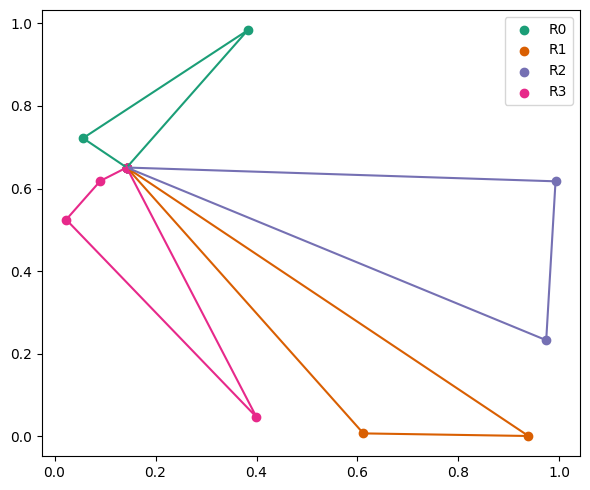

In [48]:
# Choosing colors
cmap = mpl.colormaps["Dark2"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates[t, 0]
    y = coordinates[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend()
fig.tight_layout()
plt.show()